# Demo Flow Layers - 3

> layers


In [1]:
#| default_exp demo.layers

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
from IPython.display import clear_output, DisplayHandle

def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
 #| export

# from fastai.vision.all import nn, torch, np, Path, get_image_files, Image 
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

import normflows as nf
from Noise2Model.utils import attributesFromDict
from Noise2Model.core import *

# Import required packages
import torchvision as tv

from matplotlib import pyplot as plt
from tqdm import tqdm


Now that we imported the necessary packages, we create a flow model.

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.ClassCondDiagGaussian`, which is a diagonal Gaussian with mean and standard deviation dependent on the class label of the image.


In [5]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (1, 32, 32)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 1

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.GlowBase(latent_shape)]
    # q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges,class_cond=False)

In [6]:
q0

[GlowBase(), GlowBase(), GlowBase()]

In [7]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [8]:
# Prepare training data
path = Path('../_data/Confocal_BPAE_B/')
(path).ls()

(#2) [Path('../_data/Confocal_BPAE_B/gt'),Path('../_data/Confocal_BPAE_B/raw')]

In [9]:
path_train = os.path.join(path.__str__(), "raw")
Path(path_train).ls()

(#21) [Path('../_data/Confocal_BPAE_B/raw/7'),Path('../_data/Confocal_BPAE_B/raw/3'),Path('../_data/Confocal_BPAE_B/raw/6'),Path('../_data/Confocal_BPAE_B/raw/20'),Path('../_data/Confocal_BPAE_B/raw/14'),Path('../_data/Confocal_BPAE_B/raw/12'),Path('../_data/Confocal_BPAE_B/raw/11'),Path('../_data/Confocal_BPAE_B/raw/desktop.ini'),Path('../_data/Confocal_BPAE_B/raw/15'),Path('../_data/Confocal_BPAE_B/raw/19')...]

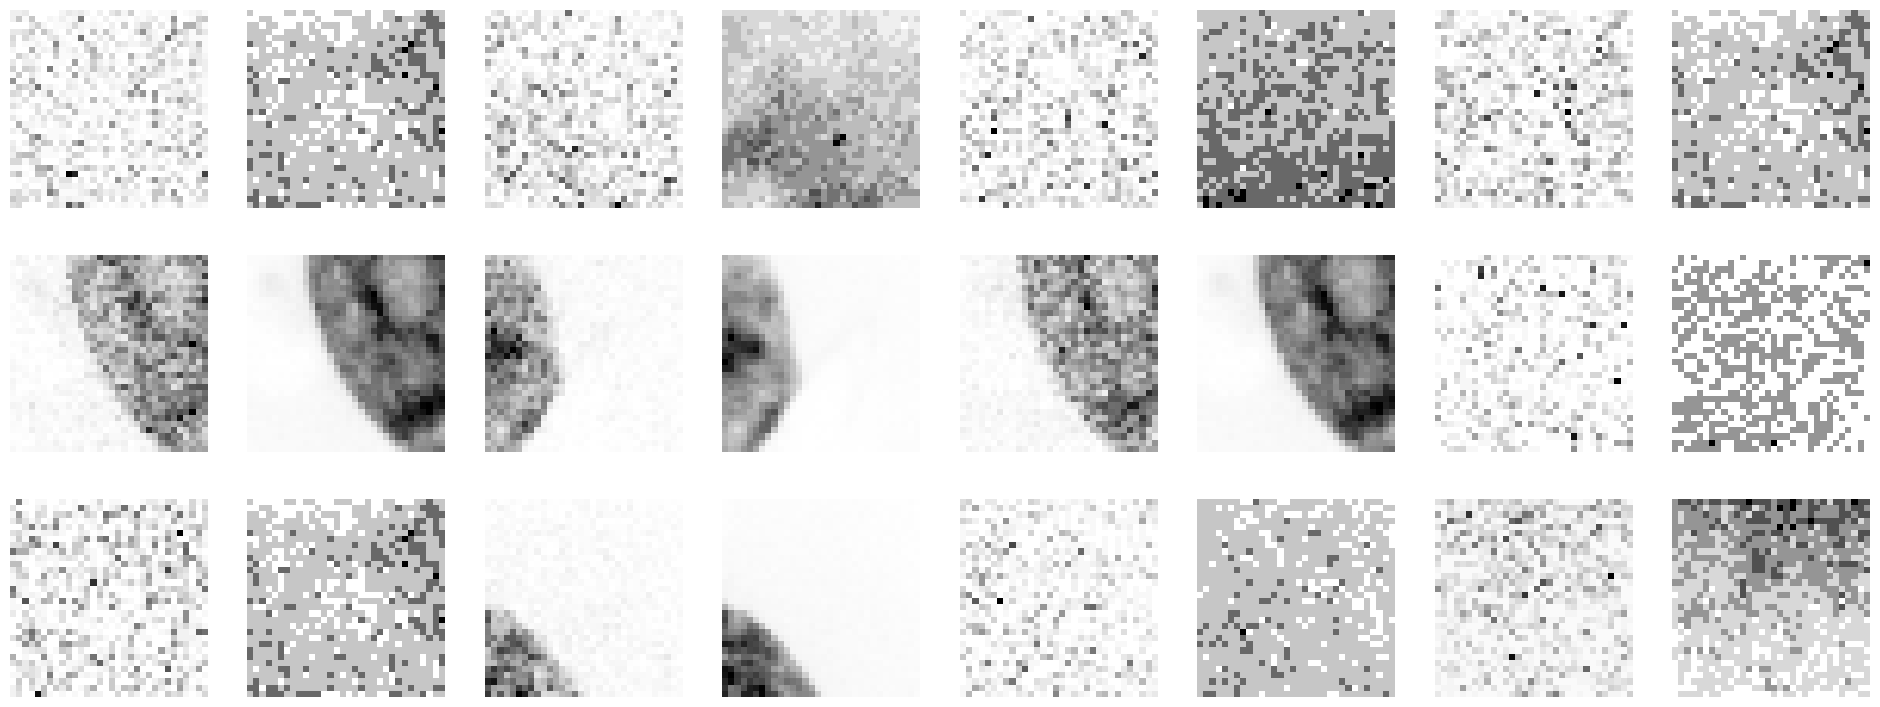

In [10]:
batch_size = 32

# transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])

data = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                    get_items=get_image_files,
                    get_y=get_gt(path),
                    item_tfms=RandomCrop(32),
                    )

dls = data.dataloaders(path_train, bs=batch_size, valid_pct=0.2, seed=42)

dls.valid.show_batch(max_n=12, nrows=3)


In [21]:
# torch.mean(dls.one_batch()[0])

In [20]:
# with torch.no_grad():
#     plt.imshow(nf.distributions.base.Uniform((32,32),0.0,1.0)(1)[0][0].numpy())
#     plt.colorbar()

## Training


In [14]:
# Train model
max_iter = 2000

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, z = next(train_iter)
    except:
        train_iter = iter(dls.train)
        x, z = next(train_iter)
    x = torch.abs(x / z)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device))
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

100%|██████████| 2000/2000 [09:38<00:00,  3.46it/s] 


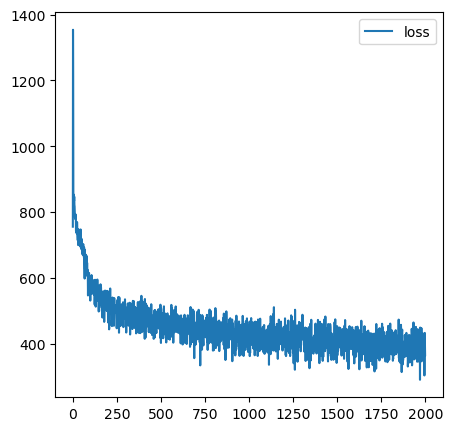

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Evaluation


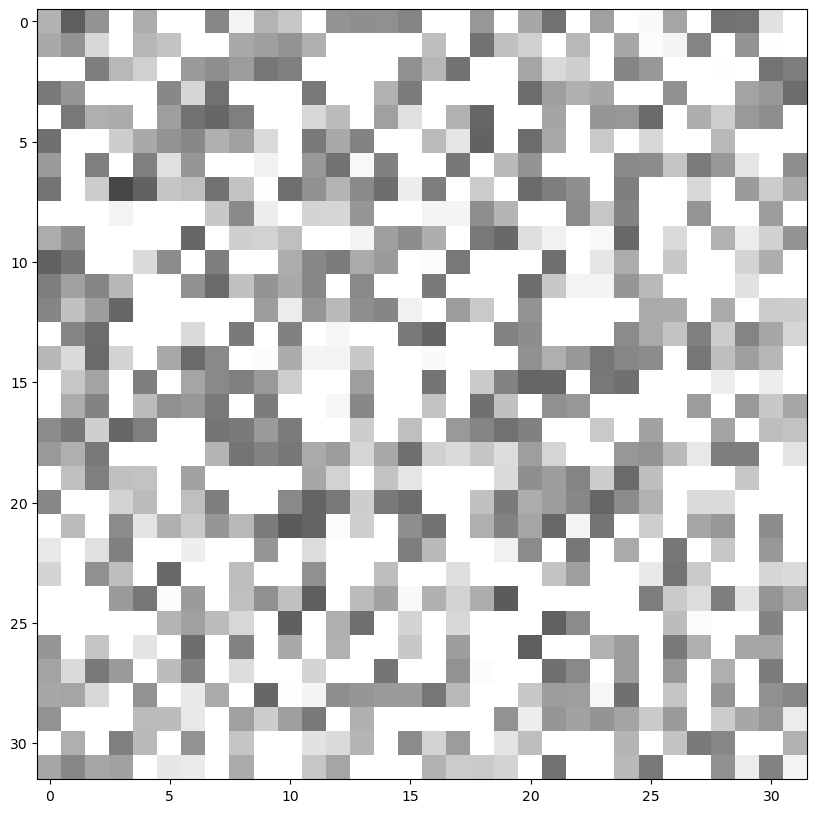

In [16]:
# Model samples
num_sample = 10

with torch.no_grad():
    x, _ = model.sample()
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_).cpu().numpy(), (1, 2, 0)))
    plt.show()